In [46]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
import ast
import models

In [47]:
df = pd.read_csv('results/auc_analysis.csv')
df2 = pd.read_csv('results/auc_analysis_other_methods.csv')
df3 = pd.read_csv('results/convnet_aucs.csv')

In [48]:
df.iloc[0].ratio

'(1, 1)'

In [49]:
df2.head(100)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50,cap
0,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-05,0.548379,0.009424,0.795643,0.000310,0.811737,0.000240,0.824414,0.000099,0.832690,0.000065,0.833195,0.000075,NaN
1,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-06,0.534905,0.008606,0.681391,0.000837,0.710880,0.000407,0.727316,0.000248,0.739475,0.000126,0.748051,0.000146,NaN
2,focal_loss,2,"(0, 1)","(10, 1)",5.000000e-07,0.527536,0.008331,0.626403,0.002741,0.652678,0.001678,0.675109,0.000896,0.692836,0.000571,0.706391,0.000421,NaN
3,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-07,0.511716,0.005766,0.629553,0.000905,0.633981,0.001234,0.642189,0.001189,0.649791,0.001168,0.657057,0.001119,NaN
4,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-08,0.514619,0.003869,0.606348,0.005053,0.618047,0.004917,0.621067,0.004912,0.621507,0.005161,0.622151,0.005368,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,weighted_focal_loss,2,"(0, 1)","(10, 1)",5.000000e-07,0.544875,0.002803,0.765963,0.000181,0.787362,0.000166,0.793631,0.000215,0.801976,0.000130,0.806772,0.000083,NaN
64,weighted_focal_loss,2,"(0, 1)","(100, 1)",1.000000e-05,0.544775,0.009107,0.504158,0.000160,0.528279,0.004045,0.516186,0.001454,0.560687,0.003222,0.523594,0.001516,NaN
65,weighted_focal_loss,2,"(0, 1)","(100, 1)",5.000000e-05,0.531304,0.005860,0.504502,0.000081,0.528695,0.001203,0.522772,0.001813,0.554471,0.003317,0.545959,0.002236,NaN
66,weighted_focal_loss,2,"(0, 1)","(100, 1)",1.000000e-06,0.515702,0.008527,0.641324,0.019075,0.680983,0.008478,0.658132,0.017960,0.645942,0.013512,0.722783,0.013886,NaN


In [50]:
df.ratio = df.ratio.apply(lambda x : ast.literal_eval(x))
df.classes_used = df.classes_used.apply(lambda x : ast.literal_eval(x))
df2.ratio = df2.ratio.apply(lambda x : ast.literal_eval(x))
df2.classes_used = df2.classes_used.apply(lambda x : ast.literal_eval(x))
df3.ratio = df3.ratio.apply(lambda x : ast.literal_eval(x))
df3.classes_used = df3.classes_used.apply(lambda x : ast.literal_eval(x))

In [51]:
# To-do: 
# loss + gradient descent 
# effective # of samples - implement + read again
# retrain w/ new learning rates 
# 2 class normal - 1e-05 - 1e-06
# 3 class results - for each class
# image augmentations? 
# try smote with MNIST 
# smote from Github 
# add focal loss and SMOTE to graphs 
# CNNs? 

# capping loss for SMOTE 

# choosing examples for SMOTE 

# focal loss + SMOTE (+ parameter updates) (less weight to synthetic examples)
    # utilize a new label - is it synthetically generated or original image 
    # how much to utilize this 
        # synthetic label correctness? 
    # changes to loss function or gradient descent to optimize learning 
    # neural network architecture? w/ embeddings and final output 
        # SMOTE on embeddings 
    # gradient updates - review current methods (Momentum, Adam) 
# loss + tune and train set accuracy every epoch to see if parameter helped 
    # what direction are examples causing weights to move 

# Done:
# 10 : 1 
# focal loss - read + implement (need to check if it works)
# try new plots - best lr? 
# smote - implement (still need to check)

# CNNs on CIFAR10 (and MNIST?) 
    # finish 3 class 
    # compare data 
    
# capping loss for SMOTE on logistic regression 



# Roadmap:

# capping loss on CNNs test 

# embeddings (2nd to last layer) + SMOTE 
    # SMOTE + capped loss with embeddings (euclidian or cosine distance) 
        # greater distance = smaller cap
            # sigmoid
        # beginning will be rlly bad, do something there (triplet/less cap)
    # triplet loss w/ SMOTE 
        # linear probing
    # combined loss function w embeddings (unsupervised learning) and final output (supervised) 
    

# lookahead feature 
    # with smote (or anything) - weight updates 
    # downweight examples 

    


    
ratio = (100,1)

NUM_CLASSES= len(ratio)

normal_df = df.loc[(df.name=='normal') & (df.num_classes==NUM_CLASSES)]
ratio_df = df.loc[(df.name=='ratio') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
oversampled_df = df.loc[(df.name=='oversampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
weighted_df = df.loc[(df.name=='weighted') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
undersampled_df = df.loc[(df.name=='undersampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
bothsampled_df = df.loc[(df.name=='both_sampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]

smote_df = df2.loc[(df2.name=='smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]


capped_smote_df10 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==10.0)]
capped_smote_df5 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==5.0)]
capped_smote_df1 = df2.loc[(df2.name=='capped_smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio) & (df2.cap==1.0)]

focalloss_df = df2.loc[(df2.name=='focal_loss') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]
weighted_focalloss_df = df2.loc[(df2.name=='weighted_focal_loss') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]


In [52]:
capped_smote_df10.head()

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50,cap
31,capped_smote,2,"(0, 1)","(100, 1)",1.000000e-05,0.543181,0.006737,0.747672,0.000878,0.761734,0.001323,0.776744,0.000328,0.778886,0.000445,0.771555,0.000435,10.0
32,capped_smote,2,"(0, 1)","(100, 1)",1.000000e-06,0.563521,0.009205,0.658209,0.003572,0.670112,0.002591,0.685586,0.001583,0.701558,0.000873,0.708945,0.000555,10.0
33,capped_smote,2,"(0, 1)","(100, 1)",5.000000e-07,0.525955,0.008097,0.648097,0.001530,0.659456,0.001272,0.668034,0.001241,0.677873,0.001064,0.686234,0.000976,10.0


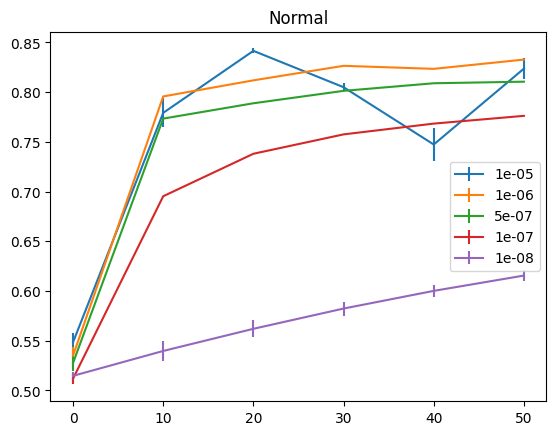

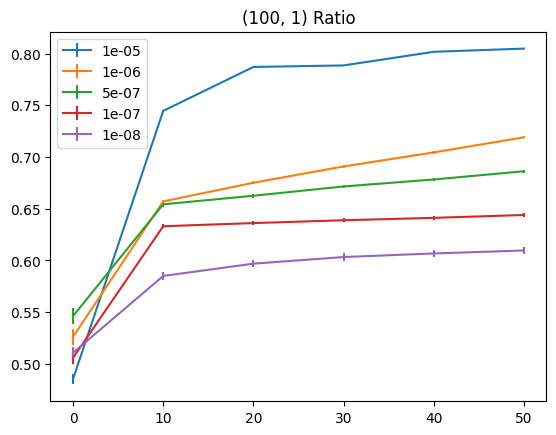

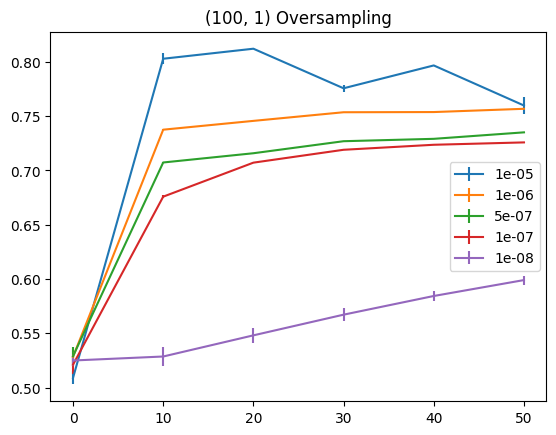

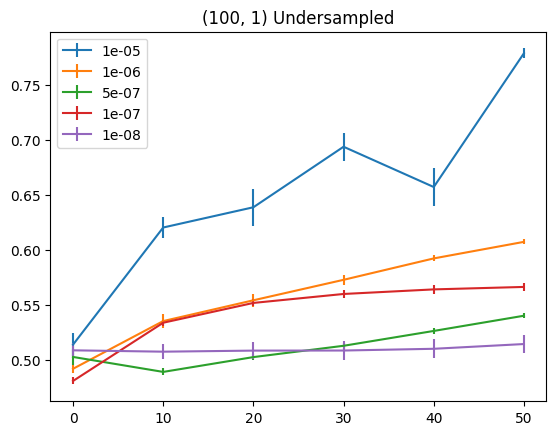

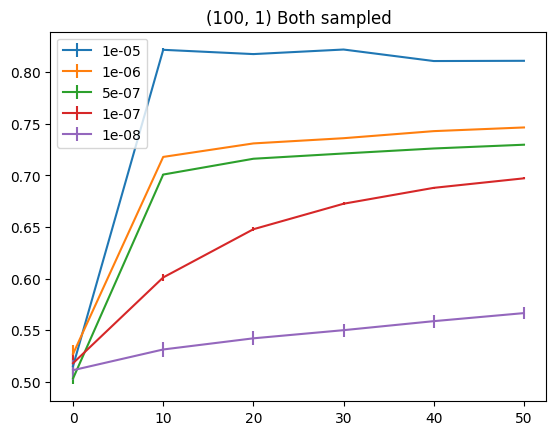

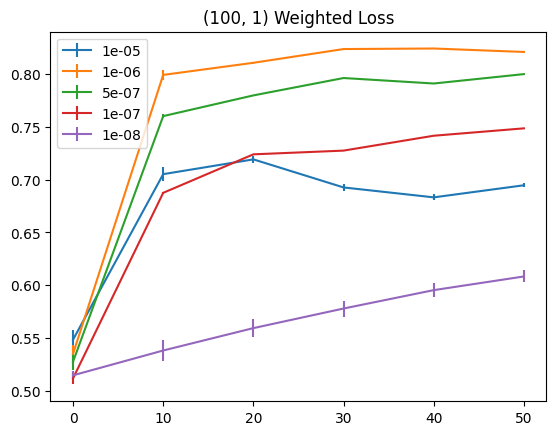

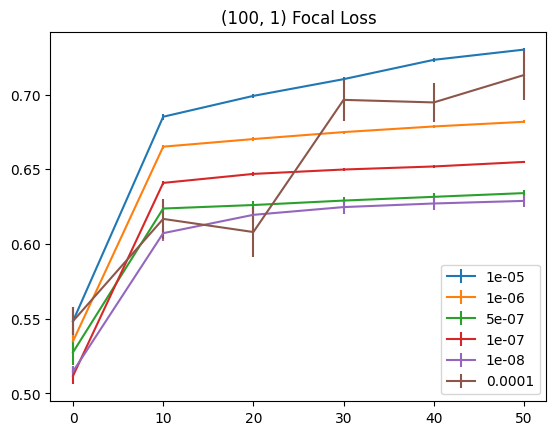

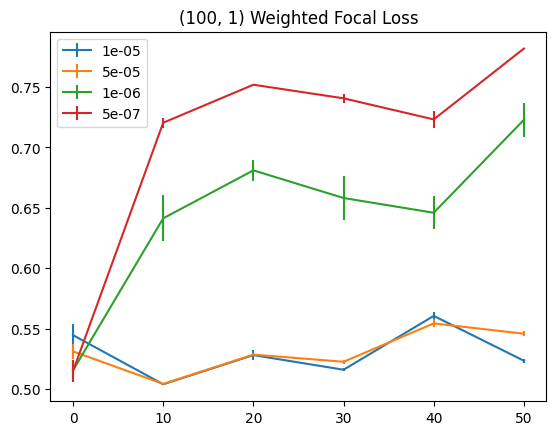

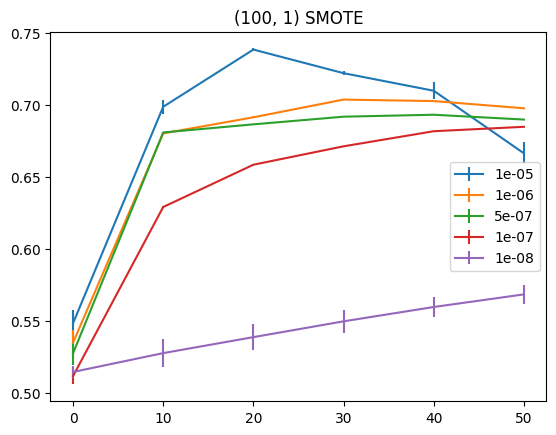

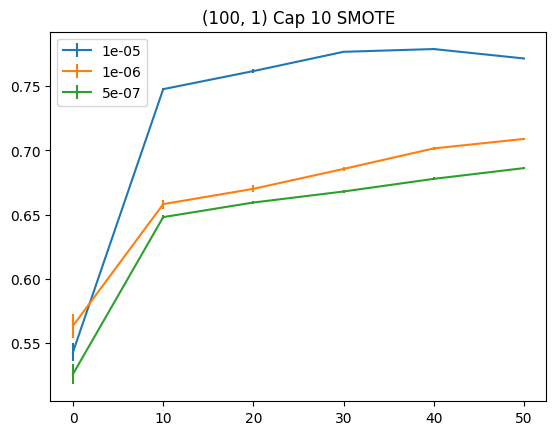

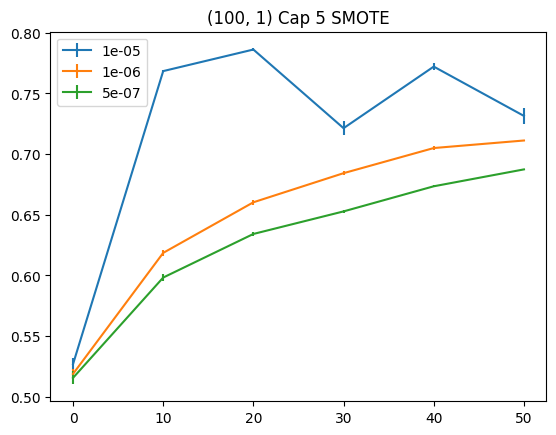

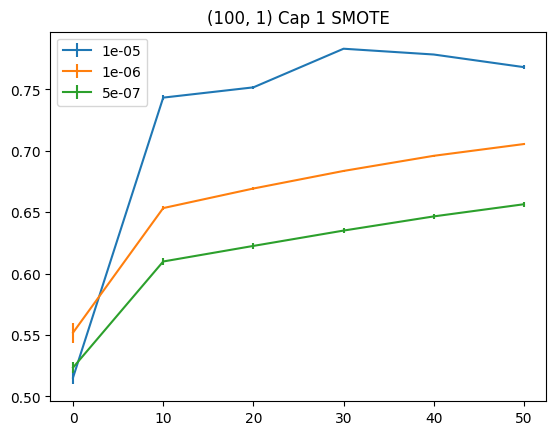

'\n\nepochs = [0, 10, 20, 30]\nmean_cols = ["mean_" + str(epoch )for epoch in epochs]\nvariance_cols = ["variance_" + str(epoch )for epoch in epochs]\n\n\n\nfor index, row in cnn_smote_df.iterrows(): \n    means = [row[mean_name] for mean_name in mean_cols]\n    variances = [row[variance] for variance in variance_cols]\n    plt.errorbar(epochs, means, yerr=variances, label=row[\'learning_rate\'])\n    if row[\'mean_30\'] >= best_mean: \n        best_lrs[row[\'name\']]=row[\'learning_rate\']\n        best_mean=row[\'mean_30\']\n    plt.title(str(row[\'ratio\']) + " SMOTE on ConvNet")\nplt.legend()\nplt.show()\n\n\n\nfor index, row in focalloss_df.iterrows(): \n    means = [row[mean_name] for mean_name in mean_cols]\n    variances = [row[variance] for variance in variance_cols]\n    plt.errorbar(epochs, means, yerr=variances, label=row[\'learning_rate\'])\n    if row[\'mean_50\'] >= best_mean: \n        best_lrs[row[\'name\']]=row[\'learning_rate\']\n        best_mean=row[\'mean_50\']\n 

In [56]:
best_lrs={}

epochs = [0, 10, 20, 30, 40, 50]
mean_cols = ["mean_" + str(epoch )for epoch in epochs]
variance_cols = ["variance_" + str(epoch )for epoch in epochs]


best_mean=0
for index, row in normal_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title("Normal")
plt.legend()
plt.show()

best_mean=0
for index, row in ratio_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Ratio")
plt.legend()
plt.show()

best_mean=0
for index, row in oversampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Oversampling")
plt.legend()
plt.show()

best_mean=0
for index, row in undersampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Undersampled")
plt.legend()
plt.show()


best_mean=0
for index, row in bothsampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Both sampled")
plt.legend()
plt.show()

best_mean=0
for index, row in weighted_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
plt.title(str(row['ratio']) + " Weighted Loss")
plt.legend()
plt.show()

best_mean=0
for index, row in focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Focal Loss")
plt.legend()
plt.show()

for index, row in weighted_focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Weighted Focal Loss")
plt.legend()
plt.show()

best_mean=0
for index, row in smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df10.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 10 SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df5.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 5 SMOTE")
plt.legend()
plt.show()

best_mean=0
for index, row in capped_smote_df1.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row[mean_cols[-1]] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row[mean_cols[-1]]
    plt.title(str(row['ratio']) + " Cap 1 SMOTE")
plt.legend()
plt.show()



"""

epochs = [0, 10, 20, 30]
mean_cols = ["mean_" + str(epoch )for epoch in epochs]
variance_cols = ["variance_" + str(epoch )for epoch in epochs]



for index, row in cnn_smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_30'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_30']
    plt.title(str(row['ratio']) + " SMOTE on ConvNet")
plt.legend()
plt.show()



for index, row in focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
    plt.title(str(row['ratio']) + " Focal Loss")
plt.legend()
plt.show()

"""

In [57]:
print(best_lrs)

{'normal': 1e-06, 'ratio': 1e-05, 'oversampled': 1e-05, 'undersampled': 1e-05, 'both_sampled': 1e-05, 'weighted': 1e-06, 'focal_loss': 1e-05, 'weighted_focal_loss': 5e-07, 'smote': 1e-06, 'capped_smote': 1e-05}


IndexError: single positional indexer is out-of-bounds

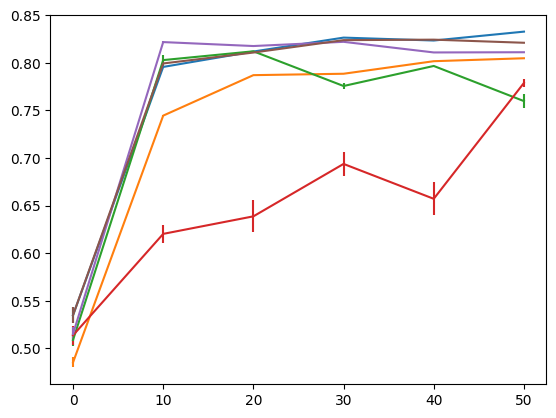

In [58]:
for key in best_lrs:
    means = []
    variances = []
    for epoch in epochs: 
        mean = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['mean_' + str(epoch)].iloc[0]

        var = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['variance_' + str(epoch)].iloc[0]
        means.append(mean)
        variances.append(var)
    plt.errorbar(epochs, means, yerr=variances, label=key + " " + str(best_lrs[key]))
plt.title(str(row['ratio']) + " at Best Learning Rates")
plt.legend()
plt.show()


In [ ]:
arr = np.zeros((100, 250, 128))

In [ ]:
np.mean(arr, axis=1).shape

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [61]:
ls = [0, 1, 0, 1, 0, 1, 0]
arr = np.array(ls)
print(arr == 0)

[ True False  True False  True False  True]
